# Семинар №3

### Чтение картинки

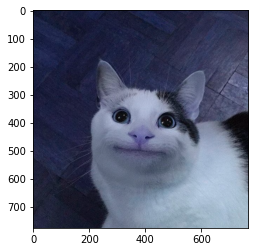

In [82]:
image = cv2.imread('./image.png')
plt.imshow(image);

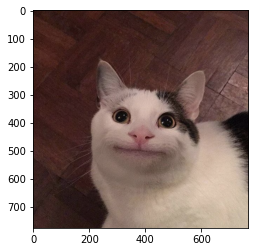

In [83]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb);

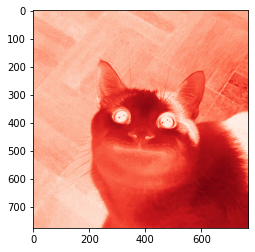

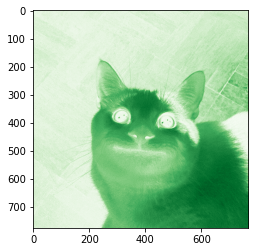

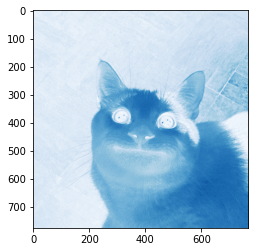

In [84]:
img_mat = np.array(image_rgb)
plt.imshow(img_mat[:, :, 0], cmap=cm.Reds)
plt.show()

img_mat = np.array(image_rgb)
plt.imshow(img_mat[:, :, 1], cmap=cm.Greens)
plt.show()

img_mat = np.array(image_rgb)
plt.imshow(img_mat[:, :, 2], cmap=cm.Blues)
plt.show()

### Операция свертки

- Количество входных каналов `in_channels`
- Количество выходных каналов `out_channels`
- Размер ядра `kernel_size`
- Шаг `stride`
- Паддинг `padding`
- Режим паддинга `padding_mode` (`'zeros'`, `'reflect'`, ...)
![alt text](conv.png "")

In [85]:
bw_image = cv2.imread('./image.png', cv2.IMREAD_GRAYSCALE)

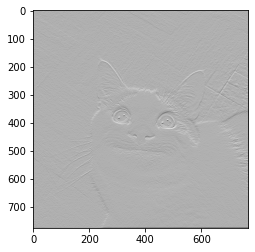

In [86]:
from scipy.signal import convolve2d

G_y = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
])

res_y = convolve2d(bw_image, G_y, "same")
plt.imshow(res_y, cmap=plt.cm.Greys_r)

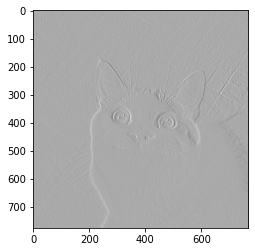

In [87]:
G_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

res_x = convolve2d(bw_image, G_y.T, "same")
plt.imshow(res_x, cmap=plt.cm.Greys_r)

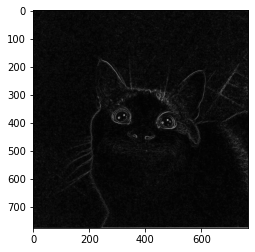

In [88]:
res_sobel = (res_x**2 + res_y**2)**0.5
plt.imshow(res_sobel, cmap=plt.cm.Greys_r)

### Свёрточная нейронная сеть для бинарной классификации

In [89]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm


import warnings
warnings.filterwarnings('ignore')

In [90]:
train_dir = "./data2/training/"
val_dir = "./data2/validation/"

In [91]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

valid_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(val_dir, transform=valid_transforms)

In [92]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')

Number of training examples: 11997
Number of validation examples: 3003


In [93]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=128, shuffle=True)

In [101]:
train_data[0]

(tensor([[[0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
          [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
          [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
          ...,
          [0.3451, 0.3451, 0.3294,  ..., 0.0980, 0.1059, 0.1098],
          [0.3255, 0.3373, 0.3294,  ..., 0.0824, 0.0863, 0.0941],
          [0.3608, 0.3569, 0.3255,  ..., 0.0627, 0.0706, 0.0745]],
 
         [[0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
          [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
          [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
          ...,
          [0.0824, 0.0824, 0.0706,  ..., 0.0353, 0.0314, 0.0275],
          [0.0745, 0.0863, 0.0863,  ..., 0.0353, 0.0353, 0.0314],
          [0.1176, 0.1137, 0.0863,  ..., 0.0392, 0.0353, 0.0314]],
 
         [[0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
          [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
          [0.0314, 0.0314, 0.0314,  ...,

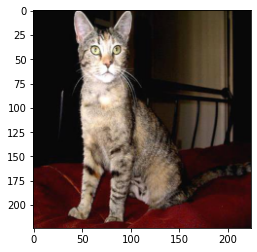

In [94]:
plt.imshow(train_data[0][0].permute(1, 2, 0))

In [96]:
model = models.resnet18(pretrained=True)

In [97]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [98]:
model.fc = nn.Linear(model.fc.in_features, 2)

In [99]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [54]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [65]:
def train(model, optimizer, n_epochs=10, device='cuda'):
    
    model = model.to(device)
    accuracies, losses = [], []
    for epoch in range(n_epochs):
        
        # обучение
        for x_train, y_train in tqdm(train_dataloader):
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # валидация
        val_loss = []
        val_accuracy = []
        with torch.no_grad():
            for x_val, y_val in tqdm(val_dataloader):
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                y_pred = model(x_val).to(device)
                loss = F.cross_entropy(y_pred, y_val)
                val_loss.append(loss.cpu().numpy())
                val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).cpu().numpy().tolist())

        accuracies.append(np.mean(val_accuracy))
        losses.append(np.mean(val_loss))
        print(f'Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}')
    return accuracies, losses

In [66]:
accs, losses = train(model, optimizer)

100%|██████████| 24/24 [00:26<00:00,  1.11s/it]


Epoch: 0, loss: 0.0509883277118206, accuracy: 0.984015984015984


100%|██████████| 24/24 [00:26<00:00,  1.09s/it]


Epoch: 1, loss: 0.04333467409014702, accuracy: 0.9853479853479854


100%|██████████| 24/24 [00:25<00:00,  1.08s/it]


Epoch: 2, loss: 0.04075995460152626, accuracy: 0.9853479853479854


100%|██████████| 24/24 [00:25<00:00,  1.08s/it]


Epoch: 3, loss: 0.03879193589091301, accuracy: 0.985014985014985


100%|██████████| 24/24 [00:25<00:00,  1.07s/it]


Epoch: 4, loss: 0.03779390826821327, accuracy: 0.9876789876789877


100%|██████████| 24/24 [00:25<00:00,  1.07s/it]


Epoch: 5, loss: 0.03829413652420044, accuracy: 0.9866799866799867


100%|██████████| 24/24 [00:25<00:00,  1.07s/it]


Epoch: 6, loss: 0.03903355076909065, accuracy: 0.9853479853479854


100%|██████████| 24/24 [00:26<00:00,  1.08s/it]


Epoch: 7, loss: 0.0364236943423748, accuracy: 0.9896769896769897


100%|██████████| 24/24 [00:25<00:00,  1.07s/it]


Epoch: 8, loss: 0.03345643728971481, accuracy: 0.9873459873459873


100%|██████████| 24/24 [00:26<00:00,  1.10s/it]

Epoch: 9, loss: 0.035565298050642014, accuracy: 0.9876789876789877


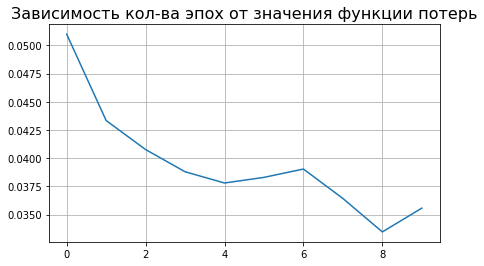

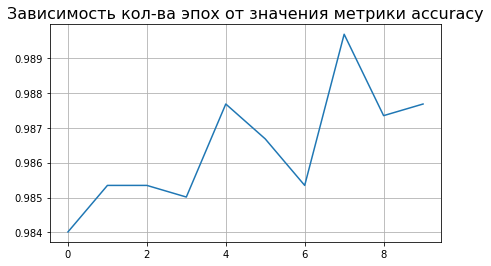

In [81]:
def plot_metrics(metric, caption):
    plt.figure(figsize=(7,4))
    plt.plot(list(range(0, 10)), metric)
    plt.title(f'Зависимость кол-ва эпох от значения {caption}', fontsize=16)
    plt.grid()
    

plot_metrics(losses, 'функции потерь')
plot_metrics(accs, 'метрики accuracy')

### Домашнее задание

- Обучите нейронную сеть на датасете indoor-outdoor и оцените её качество (3 балла)
- Для обучения введите автоматическое разбиение на train/val в пропорции 70/30 (0.5 балла)
- Постройте графики метрик качества (1 балл)
- Попробуйте поменять гиперпараметры и сделать выводы о том, как это влияет на качество (0.5 балла). 

### По желанию (*но всячески приветствуется*)
- Попробуйте вычислить F1-меру и построить confusion matrix
- При разбиение на train/val сравните результаты со стратификацией и без нее

*Цель:* выработать навык обучения нейронных сетей (в частности сверточных) на основе средств PyTorch, начиная от загрузки датасетами и заканчивая выводами результатов, их логгированием, сравнением и анализом.